In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Q2 Calcualte the term structure of interest rates

# Term Structure of Interest Rates

In [2]:
def phi_t(a, b, lamda, t):
    phit = a + b*(((1-np.exp(-lamda*t))/(lamda*t))-np.exp(-lamda*t))
    return phit

def Euler_sch(a, b, sigma, alpha, beta, eta, lamda, Nsim, Ntime, x_0, y_0):
    x = np.full((Nsim, Ntime+1), np.nan)
    y = np.full((Nsim, Ntime+1), np.nan)
    r = np.full((Nsim, Ntime+1), np.nan)
    phi = np.full((Nsim, Ntime+1), np.nan)
    phi[:,0] = a
    r[:,0] = a + x_0 + y_0
    x[:,0] = x_0
    y[:,0] = y_0
    dt = 1/252
    t = 0
    # Set initial x_0, y_0
    for i in range(Ntime):
        Z_1 = np.random.standard_normal(Nsim)
        Z_2 = np.random.standard_normal(Nsim)
        t = (i+1)*dt
        x[:,i+1] = x[:,i] - alpha*x[:,i]*dt + sigma*np.sqrt(dt)*Z_1
        y[:,i+1] = y[:,i] - beta*y[:,i]*dt + eta*np.sqrt(dt)*Z_2
        phi[:,i+1] = phi_t(a,b,lamda,t)
        r[:,i+1]= phi[:,i+1] + x[:,i+1] +y[:,i+1]
    Pt0 = np.mean(np.exp(-np.sum(r, axis=1)*dt))
    return x,y,r,Pt0

Set basic parameters

In [3]:
x_0 = -0.005
y_0 = 0.005
alpha = 3
sigma = 0.01
beta = 1
eta = 0.005
a = 0.02
b = 0.05
lamda = 0.75
Ntime = 252*10
Nsim = 1000


x = np.full((Nsim, Ntime+1),np.nan)
y = np.full((Nsim, Ntime+1),np.nan)
r = np.full((Nsim, Ntime+1),np.nan)

x,y,r,pt0 = Euler_sch(a, b, sigma, alpha, beta, eta, lamda, Nsim, Ntime, x_0, y_0)



0.7343800601930611


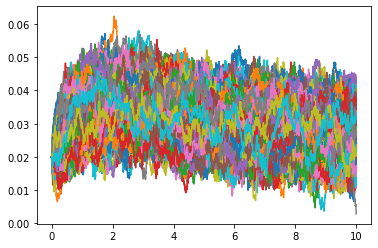

In [4]:
print(pt0)
t = np.linspace(0,10,Ntime+1)
for i in range(Nsim):
    plt.plot(t,r[i,:])
plt.show()

Q3 Use 10000 paths to obtain MC estimate of bond yields

In [5]:
# Simulation Method

def Yields_mat(a, b, sigma, alpha, beta, eta, lamda, Nsim, T, x_0, y_0):
    Pt0 = []
    yt = []
    Ntime = T*12*21
    dt = 1/252
    r = np.full((Nsim, Ntime+1), np.nan)
    r = Euler_sch(a, b, sigma, alpha, beta, eta, lamda, Nsim,Ntime, x_0, y_0)[2]
    for i in range(T*12):
        length = (i+1)*21
        pt0 = np.mean(np.exp(-np.sum(r[:,0:length],axis=1)*dt))
        Pt0 += [pt0]
        yt += [np.log(1/pt0)/((i+1)/12)]
    
    return Pt0, yt

In [6]:
from scipy.integrate import quad
def integrand(x, sigma,eta,alpha,T,beta):
    mu_t = sigma*(1-np.exp(-alpha*(T-x)))/alpha
    nu_t = eta*(1-np.exp(-beta*(T-x)))/beta
    return (mu_t**2 + nu_t**2)
def phi_t2(x, a, b, lamda):
    phit = a + b*(((1-np.exp(-lamda*x))/(lamda*x))-np.exp(-lamda*x))
    return phit

def Price_analy(a,b,lamda,sigma,eta,alpha,T,beta,y_0,x_0):
    Pt0 = []
    yt = []
    for i in range(T*12):
        At_1 = quad(phi_t2,0,(i+1)/12,args=(a,b,lamda))[0]
        At_2 = quad(integrand, 0, (i+1)/12, args=(sigma, eta, alpha, (i+1)/12, beta))[0]
        B_T = (1-np.exp(-alpha*((i+1)/12)))/alpha
        C_T = (1-np.exp(-beta*((i+1)/12)))/beta
        price = np.exp(-At_1+0.5*At_2-B_T*x_0-C_T*y_0)
        Pt0 += [price]
        yt += [np.log(1/price)/((i+1)/12)]
    #m_u = (1-np.exp(-beta*()))
    return Pt0,yt

In [11]:
x_0 = -0.005
y_0 = 0.005
alpha = 3
sigma = 0.01
beta = 1
eta = 0.005
a = 0.02
b = 0.05
lamda = 0.75
T = 10
Nsim2 = 10000
# Compute based on simulation
Pt, yt = Yields_mat(a, b, sigma, alpha, beta, eta, lamda, Nsim2,T, x_0, y_0)
# Compute analyticaly
Pt2, yt2 = Price_analy(a,b,lamda,sigma,eta,alpha,T,beta,y_0,x_0)

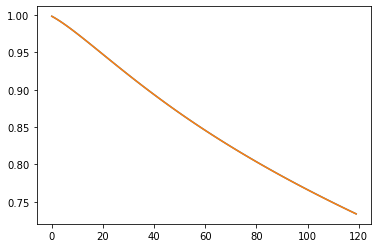

In [15]:
#print(Pt2)
len(Pt2)
plt.plot(Pt)
plt.plot(Pt2)
plt.show()
#Pt

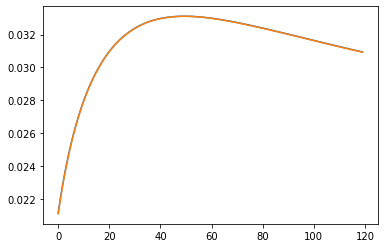

In [16]:
plt.plot(yt2)
plt.plot(yt)
plt.show()